In [10]:
# !unzip /content/drive/MyDrive/data.zip 


In [11]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting path
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Expanding path
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(1024, 512)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(256, 128)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(128, 64)

        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        x1 = self.conv1(x)
        x = self.pool1(x1)
        x2 = self.conv2(x)
        x = self.pool2(x2)
        x3 = self.conv3(x)
        x = self.pool3(x3)
        x4 = self.conv4(x)
        x = self.pool4(x4)

        # Bottleneck
        x = self.bottleneck(x)

        # Expanding path
        x = self.upconv1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.conv5(x)
        x = self.upconv2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv6(x)
        x = self.upconv3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv7(x)
        x = self.upconv4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv8(x)

        # Output layer
        x = self.out(x)

        return x

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

In [12]:
import glob
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(root_dir, '*/*'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        label = 0 if 'cat' in img_path else 1  # 0 for cat, 1 for dog
        label_tensor = torch.tensor(label, dtype=torch.float)    # label as a tensor
        
        return img, label_tensor

In [29]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F

# Load and preprocess the data
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = CustomDataset('data/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)


val_data = CustomDataset('data/validation', transform=transform)
val_loader = DataLoader(val_data, batch_size=128, shuffle=True)

test_data = CustomDataset('data_test/test', transform=transform)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Training shape: 29940 samples, 256 x 256 size RGB image.

Test shape: 24998 samples, 256 x 256 size RGB image.

Examples:


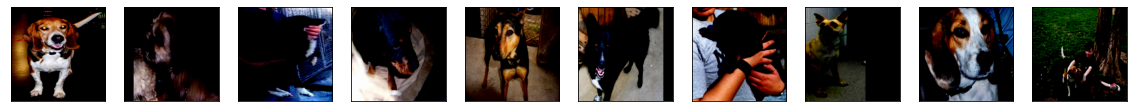

In [35]:
import torch
import matplotlib.pyplot as plt

# Assuming you have train_loader and val_loader correctly defined

# Accessing the shape of the data
img_size = train_loader.dataset[0][0].shape[1]  # Assuming the first sample in train_loader has the shape (channels, height, width)
train_samples = len(train_loader.dataset)
val_samples = len(test_loader.dataset)

print('Training shape:', train_samples, 'samples,', img_size, 'x', img_size, 'size RGB image.\n')
print('Test shape:', val_samples, 'samples,', img_size, 'x', img_size, 'size RGB image.\n')

print('Examples:')
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display some data:
    ax = plt.subplot(1, n, i)
    plt.imshow(train_loader.dataset[i][0].permute(1, 2, 0))  # Assuming the image data is in the shape (channels, height, width)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [15]:
print(val_loader)

In [16]:
import torch.optim as optim

# Define the model, loss function, and optimizer
model = UNet(in_channels=3, out_channels=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F

num_epochs = 10

for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_val_loss = 0.0
    
    # Training loop
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)  # apply sigmoid activation

        # Modify the labels tensor
        labels = labels.view(-1, 1, 1, 1).repeat(1, 2, 1, 1)

        # Upsample the labels tensor to match the spatial dimensions of the outputs tensor
        labels = F.interpolate(labels, size=outputs.shape[2:], mode='nearest')

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        if i % 10 == 9:  # print every 10 batches
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_loader)}, Training Loss: {running_train_loss/10}")
            running_train_loss = 0.0
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)  # apply sigmoid activation

            # Modify the labels tensor
            labels = labels.view(-1, 1, 1, 1).repeat(1, 2, 1, 1)

            # Upsample the labels tensor to match the spatial dimensions of the outputs tensor
            labels = F.interpolate(labels, size=outputs.shape[2:], mode='nearest')

            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

        print(f"Epoch {epoch+1}, Validation Loss: {running_val_loss/len(val_loader)}")
        running_val_loss = 0.0


Epoch 1, Batch 10/234, Training Loss: 0.24933308660984038
Epoch 1, Batch 20/234, Training Loss: 0.23390862345695496
Epoch 1, Batch 30/234, Training Loss: 0.2392229914665222
Epoch 1, Batch 40/234, Training Loss: 0.23433063924312592
Epoch 1, Batch 50/234, Training Loss: 0.23141505867242812
Epoch 1, Batch 60/234, Training Loss: 0.23606979697942734
Epoch 1, Batch 70/234, Training Loss: 0.23144619315862655
Epoch 1, Batch 80/234, Training Loss: 0.223101244866848
Epoch 1, Batch 90/234, Training Loss: 0.22373311519622802
Epoch 1, Batch 100/234, Training Loss: 0.2177554816007614
Epoch 1, Batch 110/234, Training Loss: 0.2208699941635132
Epoch 1, Batch 120/234, Training Loss: 0.21680307686328887
Epoch 1, Batch 130/234, Training Loss: 0.21466249525547026
Epoch 1, Batch 140/234, Training Loss: 0.2131193220615387
Epoch 1, Batch 150/234, Training Loss: 0.2151606097817421
Epoch 1, Batch 160/234, Training Loss: 0.21701336205005645
Epoch 1, Batch 170/234, Training Loss: 0.21461071968078613
Epoch 1, Batc

In [19]:
torch.save(model.state_dict(), 'unet-1.pth')

In [20]:
model = UNet(in_channels=3, out_channels=2)
model.load_state_dict(torch.load('unet-1.pth'))

# Access the state dictionary
state_dict = model.state_dict()

# Print the shapes of the model's weights
for name, param in state_dict.items():
    print(f'Parameter: {name}\tShape: {param.shape}')


Parameter: conv1.conv1.weight	Shape: torch.Size([64, 3, 3, 3])
Parameter: conv1.conv1.bias	Shape: torch.Size([64])
Parameter: conv1.bn1.weight	Shape: torch.Size([64])
Parameter: conv1.bn1.bias	Shape: torch.Size([64])
Parameter: conv1.bn1.running_mean	Shape: torch.Size([64])
Parameter: conv1.bn1.running_var	Shape: torch.Size([64])
Parameter: conv1.bn1.num_batches_tracked	Shape: torch.Size([])
Parameter: conv1.conv2.weight	Shape: torch.Size([64, 64, 3, 3])
Parameter: conv1.conv2.bias	Shape: torch.Size([64])
Parameter: conv1.bn2.weight	Shape: torch.Size([64])
Parameter: conv1.bn2.bias	Shape: torch.Size([64])
Parameter: conv1.bn2.running_mean	Shape: torch.Size([64])
Parameter: conv1.bn2.running_var	Shape: torch.Size([64])
Parameter: conv1.bn2.num_batches_tracked	Shape: torch.Size([])
Parameter: conv2.conv1.weight	Shape: torch.Size([128, 64, 3, 3])
Parameter: conv2.conv1.bias	Shape: torch.Size([128])
Parameter: conv2.bn1.weight	Shape: torch.Size([128])
Parameter: conv2.bn1.bias	Shape: torch

In [21]:
class UNetEncoder(nn.Module):
    def __init__(self, model):
        super(UNetEncoder, self).__init__()

        # Contracting path
        self.conv1 = model.conv1
        self.pool1 = model.pool1
        self.conv2 = model.conv2
        self.pool2 = model.pool2
        self.conv3 = model.conv3
        self.pool3 = model.pool3
        self.conv4 = model.conv4
        self.pool4 = model.pool4

    def forward(self, x):
        # Contracting path
        x1 = self.conv1(x)
        x = self.pool1(x1)
        x2 = self.conv2(x)
        x = self.pool2(x2)
        x3 = self.conv3(x)
        x = self.pool3(x3)
        x4 = self.conv4(x)
        x = self.pool4(x)

        return x
    
    def get_flattened_size(self):
        # Retrieve the size of the output tensor after the encoder layers
        sample_input = torch.zeros(1, 3, 256, 256)  # Adjust the input size according to your data
        features = self.forward(sample_input)
        flattened_size = features.view(features.size(0), -1).shape[1]
        return flattened_size


class CatDogClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(CatDogClassifier, self).__init__()
        self.encoder = encoder

        # Adjust the flattened_size based on the output size of the encoder
        flattened_size = encoder.get_flattened_size()
        self.fc1 = nn.Linear(flattened_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.encoder(x)  # Pass the input through the encoder
        features = features.view(features.size(0), -1)  # Flatten the features

        x = self.fc1(features)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [23]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [25]:
# Step 6: Train the model
num_epochs = 10
# Step 6: Create an instance of the CatDogClassifier
num_classes = 2  # Number of classes (cat and dog)
encoder = UNetEncoder(model)  # Assuming `model` is your existing UNet model
classifier = CatDogClassifier(encoder, num_classes)
# Step 4: Define loss function and optimizer
optimizer1 = optim.Adam(classifier.parameters())
criterion = nn.CrossEntropyLoss()


for epoch in range(num_epochs):
    # Training
    classifier.train()  # Set the model to train mode
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        optimizer1.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = classifier(images)

        # Compute loss
        loss = criterion(outputs, labels.long())  # Convert labels to torch.long
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer1.step()

        # Track the number of correct predictions
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_loader.dataset)

    # Validation
    classifier.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = classifier(images)
            outputs = torch.softmax(outputs, dim=1)

            # Compute loss
            loss = torch.nn.functional.cross_entropy(outputs, labels.long())
            val_loss += loss.item()

            # Track the number of correct predictions
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the validation set
    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_loader.dataset)

    # Print the epoch results
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
    print()


Epoch 1/10:
Train Loss: 2.0505 | Train Accuracy: 0.6491
Val Loss: 0.5821 | Val Accuracy: 0.7364

Epoch 2/10:
Train Loss: 0.3907 | Train Accuracy: 0.8229
Val Loss: 0.4746 | Val Accuracy: 0.8364

Epoch 3/10:
Train Loss: 0.2581 | Train Accuracy: 0.8913
Val Loss: 0.6113 | Val Accuracy: 0.6727

Epoch 4/10:
Train Loss: 0.1727 | Train Accuracy: 0.9299
Val Loss: 0.5025 | Val Accuracy: 0.8000

Epoch 5/10:
Train Loss: 0.1294 | Train Accuracy: 0.9488
Val Loss: 0.5101 | Val Accuracy: 0.8091

Epoch 6/10:
Train Loss: 0.0841 | Train Accuracy: 0.9681
Val Loss: 0.5179 | Val Accuracy: 0.7818

Epoch 7/10:
Train Loss: 0.0713 | Train Accuracy: 0.9736
Val Loss: 0.4098 | Val Accuracy: 0.8818

Epoch 8/10:
Train Loss: 0.0624 | Train Accuracy: 0.9766
Val Loss: 0.4930 | Val Accuracy: 0.8091

Epoch 9/10:
Train Loss: 0.0401 | Train Accuracy: 0.9845
Val Loss: 0.4004 | Val Accuracy: 0.9091

Epoch 10/10:
Train Loss: 0.0403 | Train Accuracy: 0.9847
Val Loss: 0.4674 | Val Accuracy: 0.8364



In [27]:
torch.save(model.state_dict(), 'classifier-unet.pth')

In [30]:
classifier.eval()  # Set the model to evaluation mode

test_loss = 0.0
test_correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.long()  # Convert labels to torch.long

        # Forward pass
        outputs = classifier(images)

        # Compute loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Track the number of correct predictions
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy for the test set
test_loss /= len(test_loader)
test_accuracy = test_correct / len(test_loader.dataset)

# Print the test results
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.7102 | Test Accuracy: 0.8609


In [39]:
import torch
from PIL import Image
from torchvision import transforms

# Load the image
image_path = "data_test/test/new_dog/1123.jpg"
image = Image.open(image_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_image = transform(image).unsqueeze(0)

# Set the model to evaluation mode
classifier.eval()

# Forward pass through the model
with torch.no_grad():
    output = classifier(input_image)

# Get the predicted class
_, predicted = torch.max(output.data, 1)
class_index = predicted.item()

# Define the class labels
class_labels = ['cat', 'dog']

# Print the predicted class label
predicted_label = class_labels[class_index]
print("Predicted Label:", predicted_label)


Predicted Label: dog
